In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys
import xmltodict, json

from itertools import chain

In [3]:
### Seaboarn Theme

sns.set_palette("YlGnBu")
sns.set(font="NanumGothic")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={'axes.titlesize':20})

### Directories

In [4]:
# go to parent directory
os.chdir("../..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "Stanford Dogs"
DATA_BASE_PATH = paths.get_data_path() / "stanford-dogs-dataset"


# set path to repo_dir
os.chdir(REPO_DIR)

## Loading Data

In [5]:
df_path = DATA_BASE_PATH / 'dogs_df.csv'
dogs_df = pd.read_csv(df_path)

In [71]:
from sklearn.preprocessing import LabelEncoder
breed_name_enc = LabelEncoder()
dogs_df['breed_label'] = breed_name_enc.fit_transform(dogs_df['breed'])

## EDA

### Class Distribution

Mean: 171.5
Max: 252
Min: 148


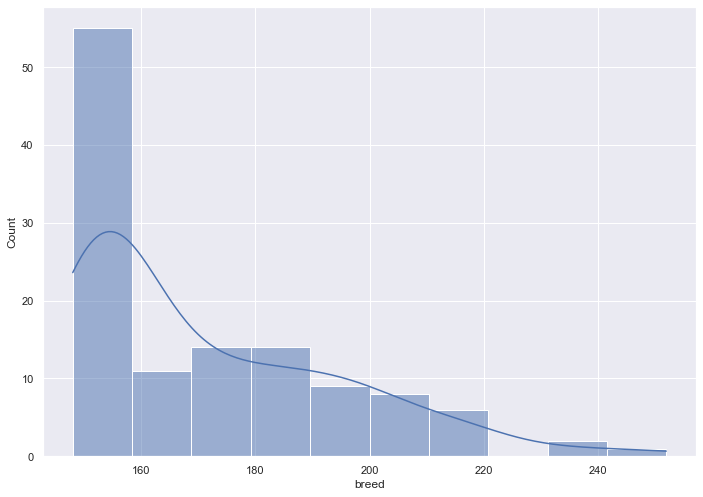

In [70]:
# boxplot
breed_count = dogs_df.breed.value_counts()

# plot_box = sns.boxplot(x=breed_count, showfliers=False)
# plot_box.set(xlabel="Count", title="Breed Count Boxplot")
plot = sns.histplot(breed_count, kde=True, bins=10)

print(f'''Mean: {breed_count.mean()}
Max: {breed_count.max()}
Min: {breed_count.min()}''')


#### We can see that most of the breeds have around 160-170 images. 
This seems to be a small number of images so we will need to augment the data and increase the number of images per class.

### Image Size

In [30]:
def get_image_size(Json_path):
    with open(Json_path) as f:
        data = json.load(f)
        size = data['annotation']['size']
        size = {'height': int(size['height']), 'width': int(size['width'])}
        return size

sizes = pd.DataFrame([get_image_size(json_file) for json_file in dogs_df.annotation_json_path])

sizes

,height,width
0,500,333
1,495,395
2,298,500
3,500,345
4,484,322
...,...,...
20575,375,500
20576,333,500
20577,300,202
20578,400,600


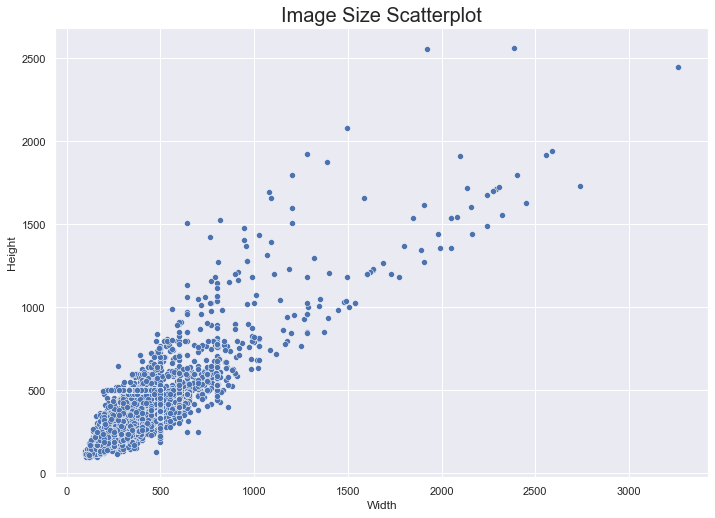

In [31]:
plot = sns.scatterplot(data=sizes, x='width', y='height')
plot.set(xlabel="Width", ylabel="Height", title="Image Size Scatterplot")
plt.show()

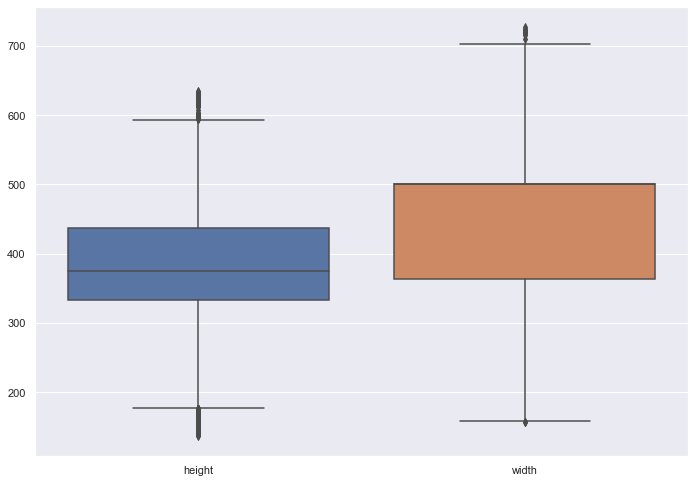

In [32]:
h_mean = sizes.height.mean()
h_std = sizes.height.std()
w_mean = sizes.width.mean()
w_std = sizes.width.std()

sizes_inbound = sizes[(sizes.height < h_mean + 2 * h_std) & (sizes.height > h_mean - 2 * h_std) & (sizes.width < w_mean + 2 * w_std) & (sizes.width > w_mean - 2 * w_std)]
plot = sns.boxplot(data=sizes_inbound)

We can say that the size of the images are around 350-450 pixels

We can set a standard size for all the images as **384x384** <br>
It will give us **12x12** grid for the YOLO model

### Bounding Box Size

In [33]:
def get_image_size(Json_path):
    sizes = []
    with open(Json_path) as f:
        objects = json.load(f)['annotation']['object']
    if type(objects) == list:
        for obj in objects:
            size = obj['bndbox']
            size = {'height': int(size['ymax']) - int(size['ymin']), 'width': int(size['xmax']) - int(size['xmin'])}
            sizes.append(size)
    else:
        size = objects['bndbox']
        size = {'height': int(size['ymax']) - int(size['ymin']), 'width': int(size['xmax']) - int(size['xmin'])}
        sizes.append(size)
    return sizes
    

sizes_ = [get_image_size(json_file) for json_file in dogs_df.annotation_json_path]

sizes = []
for size in sizes_:
    sizes+=size
sizes = pd.DataFrame(sizes)

sizes

,height,width
0,488,251
1,484,344
2,207,193
3,471,312
4,348,152
...,...,...
22121,332,451
22122,260,170
22123,212,274
22124,194,304


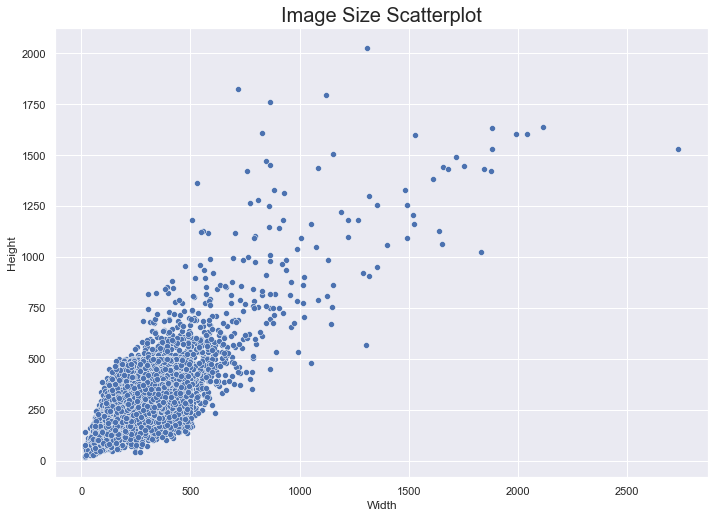

In [35]:
plot = sns.scatterplot(data=sizes, x='width', y='height')
plot.set(xlabel="Width", ylabel="Height", title="Image Size Scatterplot")
plt.show()

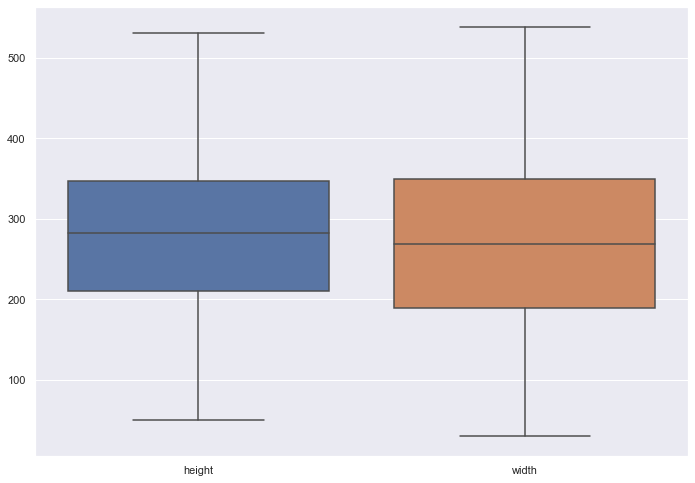

In [36]:
h_mean = sizes.height.mean()
h_std = sizes.height.std()
w_mean = sizes.width.mean()
w_std = sizes.width.std()

sizes_inbound = sizes[(sizes.height < h_mean + 2 * h_std) & (sizes.height > h_mean - 2 * h_std) & (sizes.width < w_mean + 2 * w_std) & (sizes.width > w_mean - 2 * w_std)]
plot = sns.boxplot(data=sizes_inbound)

We can say that the size of the Bounding box is around 250-350 pixels

## Loading Data

In [65]:
def data_generator(image_list, annotation_list, label_list, batch_size):
    

{'name': 'Chihuahua', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '25', 'ymin': '10', 'xmax': '276', 'ymax': '498'}}


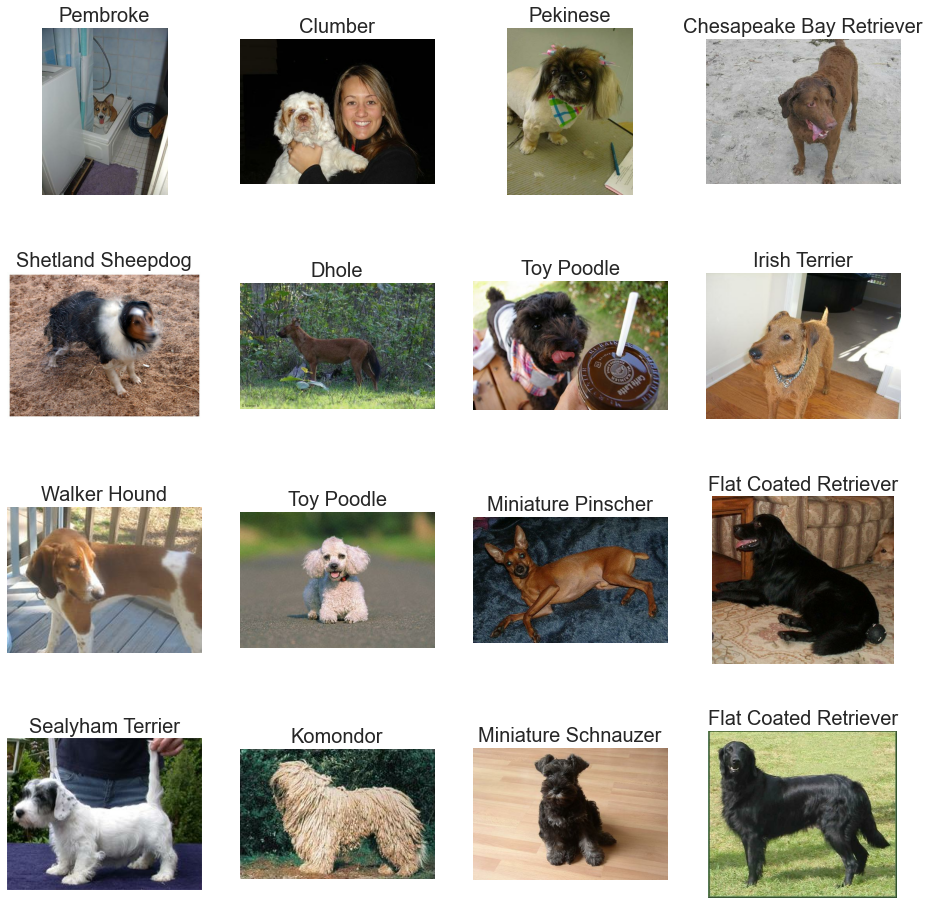

In [63]:
n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
breeds_, images_, _, a_data_ = dogs_df.sample(n_rows*n_cols).values.T

for i in range(1, n_rows*n_cols + 1):
    ax = plt.subplot(n_rows, n_cols, i)
    ax.set_title(breeds_[i-1])
    image_ = tf.image.decode_jpeg(tf.io.read_file(images_[i-1]))
    ax.imshow(image_)
    
    plt.subplots_adjust(hspace=0.4)
    
    ax.axis("off")

In [55]:
breeds_, images_, _, a_data_ = dogs_df.sample(n_rows*n_cols).values.T

## Slide Show

In [56]:
breeds_

array(['Samoyed', 'Norwegian Elkhound', 'Norfolk Terrier', 'Bloodhound',
       'Old English Sheepdog', 'Pomeranian', 'Irish Wolfhound',
       'Soft Coated Wheaten Terrier', 'Irish Terrier', 'Dandie Dinmont',
       'Saint Bernard', 'African Hunting Dog', 'Pomeranian',
       'Siberian Husky', 'Bedlington Terrier', 'Malinois'], dtype=object)